# Grover's algorithm for 4 qubits (ex: finding the entry 1010)

## Building our circuit and equal superposition initialization

Let's build our circuit with 7 qubits 
* 4 qubits for input
* 1 qubit for storing the |-> state
* 2 ancilla qubits (as will be explained bellow)

And our answer will be stored in a classical register of size 4 

Further, we intialize our input in an equal superposition of all possible states

In [1]:
# run this cell if you dont have qiskit intsalled yet
!pip install qiskit==0.20.0
from IPython.display import clear_output
clear_output()

In [2]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

## Let's start building the circuit 

In [3]:
q = QuantumRegister(7)
c = ClassicalRegister(4)
qc = QuantumCircuit(q, c)

In [4]:
# initialize in a superposition of all possible states 
qc.x(q[4])
qc.h(q[0:5])
qc.barrier(q)
qc.draw()

┌───┐      ░ 
q0_0: ┤ H ├──────░─
      ├───┤      ░ 
q0_1: ┤ H ├──────░─
      ├───┤      ░ 
q0_2: ┤ H ├──────░─
      ├───┤      ░ 
q0_3: ┤ H ├──────░─
      ├───┤┌───┐ ░ 
q0_4: ┤ X ├┤ H ├─░─
      └───┘└───┘ ░ 
q0_5: ───────────░─
                 ░ 
q0_6: ───────────░─
                 ░ 
c0: 4/═════════════

## Complete circuit diagram

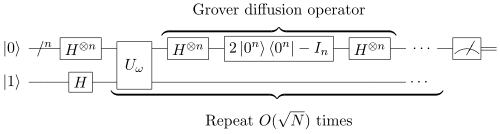

<center>source: wikipedia</center>

## Let's build the required oracle 

As an example I have built an oracle which check for the state |1010>

The gate named as "mct" is a Multi CNOT gate similar to a generalized CNOT discussed in class. here is it's documentation: https://qiskit.org/documentation/api/qiskit.aqua.circuits.gates.mct.html

We have to use a few ancilla qubits as which tend to follow the rule of "n-2" where "n" is the number of control qubits being used. we need 4 control qubits so we require 2 ancilla qubits. 

Another set of gates being used below are U1, U2 and U3. These are the physical gates that are implementatable on real hardware being provided by IBM Q services. Page 4 of https://arxiv.org/pdf/1807.01703.pdf paper has unitary matrix representation of these gates for your reference. 

In [5]:
qc.barrier(q)

# build oracle. ex: to find 1010 state
qc.x(q[1])
qc.x(q[3])
qc.barrier(q)
qc.mct([q[0], q[1], q[2], q[3]], q[4], q[5:7])    # control qubits, target qubit, ancilla qubits = number of control qubits - 2
qc.barrier(q)
qc.x(q[1])
qc.x(q[3])

qc.barrier(q)
qc.draw()

┌───┐      ░  ░       ░       ░       ░ 
q0_0: ┤ H ├──────░──░───────░───■───░───────░─
      ├───┤      ░  ░ ┌───┐ ░   │   ░ ┌───┐ ░ 
q0_1: ┤ H ├──────░──░─┤ X ├─░───■───░─┤ X ├─░─
      ├───┤      ░  ░ └───┘ ░   │   ░ └───┘ ░ 
q0_2: ┤ H ├──────░──░───────░───■───░───────░─
      ├───┤      ░  ░ ┌───┐ ░   │   ░ ┌───┐ ░ 
q0_3: ┤ H ├──────░──░─┤ X ├─░───■───░─┤ X ├─░─
      ├───┤┌───┐ ░  ░ └───┘ ░ ┌─┴─┐ ░ └───┘ ░ 
q0_4: ┤ X ├┤ H ├─░──░───────░─┤ X ├─░───────░─
      └───┘└───┘ ░  ░       ░ └───┘ ░       ░ 
q0_5: ───────────░──░───────░───────░───────░─
                 ░  ░       ░       ░       ░ 
q0_6: ───────────░──░───────░───────░───────░─
                 ░  ░       ░       ░       ░ 
c0: 4/════════════════════════════════════════

## Amplitude Amplification (Diffusion Operator)

this is equivalent to flip about the mean operation geometrically. Also known as the amplitude amplification step as we are increasing the amplitudes(probability) of the entries that we flipped(gave a - phase to) in the previous step while applying our oracle. 

In [6]:
qc.barrier(q)
qc.h(q[0:4])
qc.x(q[0:4])
qc.barrier(q)
qc.h(q[3])
qc.barrier(q)
qc.mct([q[0], q[1], q[2]], q[3], q[5:6])   
qc.barrier(q)
qc.h(q[3])
qc.barrier(q)
qc.x(q[0:4])
qc.h(q[0:4])
qc.barrier(q)
qc.draw()

┌───┐      ░  ░       ░       ░       ░  ░ ┌───┐┌───┐ ░       ░       ░ »
q0_0: ┤ H ├──────░──░───────░───■───░───────░──░─┤ H ├┤ X ├─░───────░───■───░─»
      ├───┤      ░  ░ ┌───┐ ░   │   ░ ┌───┐ ░  ░ ├───┤├───┤ ░       ░   │   ░ »
q0_1: ┤ H ├──────░──░─┤ X ├─░───■───░─┤ X ├─░──░─┤ H ├┤ X ├─░───────░───■───░─»
      ├───┤      ░  ░ └───┘ ░   │   ░ └───┘ ░  ░ ├───┤├───┤ ░       ░   │   ░ »
q0_2: ┤ H ├──────░──░───────░───■───░───────░──░─┤ H ├┤ X ├─░───────░───■───░─»
      ├───┤      ░  ░ ┌───┐ ░   │   ░ ┌───┐ ░  ░ ├───┤├───┤ ░ ┌───┐ ░ ┌─┴─┐ ░ »
q0_3: ┤ H ├──────░──░─┤ X ├─░───■───░─┤ X ├─░──░─┤ H ├┤ X ├─░─┤ H ├─░─┤ X ├─░─»
      ├───┤┌───┐ ░  ░ └───┘ ░ ┌─┴─┐ ░ └───┘ ░  ░ └───┘└───┘ ░ └───┘ ░ └───┘ ░ »
q0_4: ┤ X ├┤ H ├─░──░───────░─┤ X ├─░───────░──░────────────░───────░───────░─»
      └───┘└───┘ ░  ░       ░ └───┘ ░       ░  ░            ░       ░       ░ »
q0_5: ───────────░──░───────░───────░───────░──░────────────░───────░───────░─»
                 ░  ░       ░       ░       ░  ░            ░       ░       ░ »
q0_6: ───────────░──░───────░───────░───────░──░────────────░───────░───────░─»
                 ░  ░       ░       ░       ░  ░            ░       ░       ░ »
c0: 4/════════════════════════════════════════════════════════════════════════»
                                                                              »
«            ░ ┌───┐┌───┐ ░ 
«q0_0: ──────░─┤ X ├┤ H ├─░─
«            ░ ├───┤├───┤ ░ 
«q0_1: ──────░─┤ X ├┤ H ├─░─
«            ░ ├───┤├───┤ ░ 
«q0_2: ──────░─┤ X ├┤ H ├─░─
«      ┌───┐ ░ ├───┤├───┤ ░ 
«q0_3: ┤ H ├─░─┤ X ├┤ H ├─░─
«      └───┘ ░ └───┘└───┘ ░ 
«q0_4: ──────░────────────░─
«            ░            ░ 
«q0_5: ──────░────────────░─
«            ░            ░ 
«q0_6: ──────░────────────░─
«            ░            ░ 
«c0: 4/═════════════════════
«

## Adding measurements 

In [7]:
qc.measure(q[0:4], c[0:4])
qc.draw()

┌───┐      ░  ░       ░       ░       ░  ░ ┌───┐┌───┐ ░       ░       ░ »
q0_0: ┤ H ├──────░──░───────░───■───░───────░──░─┤ H ├┤ X ├─░───────░───■───░─»
      ├───┤      ░  ░ ┌───┐ ░   │   ░ ┌───┐ ░  ░ ├───┤├───┤ ░       ░   │   ░ »
q0_1: ┤ H ├──────░──░─┤ X ├─░───■───░─┤ X ├─░──░─┤ H ├┤ X ├─░───────░───■───░─»
      ├───┤      ░  ░ └───┘ ░   │   ░ └───┘ ░  ░ ├───┤├───┤ ░       ░   │   ░ »
q0_2: ┤ H ├──────░──░───────░───■───░───────░──░─┤ H ├┤ X ├─░───────░───■───░─»
      ├───┤      ░  ░ ┌───┐ ░   │   ░ ┌───┐ ░  ░ ├───┤├───┤ ░ ┌───┐ ░ ┌─┴─┐ ░ »
q0_3: ┤ H ├──────░──░─┤ X ├─░───■───░─┤ X ├─░──░─┤ H ├┤ X ├─░─┤ H ├─░─┤ X ├─░─»
      ├───┤┌───┐ ░  ░ └───┘ ░ ┌─┴─┐ ░ └───┘ ░  ░ └───┘└───┘ ░ └───┘ ░ └───┘ ░ »
q0_4: ┤ X ├┤ H ├─░──░───────░─┤ X ├─░───────░──░────────────░───────░───────░─»
      └───┘└───┘ ░  ░       ░ └───┘ ░       ░  ░            ░       ░       ░ »
q0_5: ───────────░──░───────░───────░───────░──░────────────░───────░───────░─»
                 ░  ░       ░       ░       ░  ░            ░       ░       ░ »
q0_6: ───────────░──░───────░───────░───────░──░────────────░───────░───────░─»
                 ░  ░       ░       ░       ░  ░            ░       ░       ░ »
c0: 4/════════════════════════════════════════════════════════════════════════»
                                                                              »
«            ░ ┌───┐┌───┐ ░ ┌─┐         
«q0_0: ──────░─┤ X ├┤ H ├─░─┤M├─────────
«            ░ ├───┤├───┤ ░ └╥┘┌─┐      
«q0_1: ──────░─┤ X ├┤ H ├─░──╫─┤M├──────
«            ░ ├───┤├───┤ ░  ║ └╥┘┌─┐   
«q0_2: ──────░─┤ X ├┤ H ├─░──╫──╫─┤M├───
«      ┌───┐ ░ ├───┤├───┤ ░  ║  ║ └╥┘┌─┐
«q0_3: ┤ H ├─░─┤ X ├┤ H ├─░──╫──╫──╫─┤M├
«      └───┘ ░ └───┘└───┘ ░  ║  ║  ║ └╥┘
«q0_4: ──────░────────────░──╫──╫──╫──╫─
«            ░            ░  ║  ║  ║  ║ 
«q0_5: ──────░────────────░──╫──╫──╫──╫─
«            ░            ░  ║  ║  ║  ║ 
«q0_6: ──────░────────────░──╫──╫──╫──╫─
«            ░            ░  ║  ║  ║  ║ 
«c0: 4/══════════════════════╩══╩══╩══╩═
«                            0  1  2  3

In case you would like to learn more about how the `mct()` gate, i.e, the multiple controlled toffoli gate is decomposed you can check out section [this](https://arxiv.org/pdf/quant-ph/9503016.pdf) paper 

## Checking our results after running it on a simulator

Note that we have not yet used a real quantum computer as they as noisy. We could however do so by changing our provider from 'ibmq_qasm_simulator' to the hardware backend you like. 

In [8]:
# running and getting results 

backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)

# if you would like to use the wasm simulator on the cloud then comment the above lines and uncomment the lines below 
# backend = provider.get_backend('ibmq_qasm_simulator')
# job = execute(qc, backend=backend, shots=8000, seed_simulator=12345, backend_options={"fusion_enable":True})
result = job.result()
count = result.get_counts()
print(count)

{'0000': 49, '0001': 34, '0010': 35, '0011': 35, '0100': 35, '0101': 475, '0110': 37, '0111': 29, '1000': 32, '1001': 40, '1010': 33, '1011': 35, '1100': 27, '1101': 34, '1110': 32, '1111': 38}


In [9]:
# the code snippet below can be used to retreive your job in case your jupyter notebook loses connection with IBMQ servers before completion of the job

# backend = provider.get_backend('ibmq_qasm_simulator')
# job = backend.retrieve_job('enter your job id here. it can be found in your IBM Q Experience dashboard')
# counts = job.result().get_counts()
# print(counts)

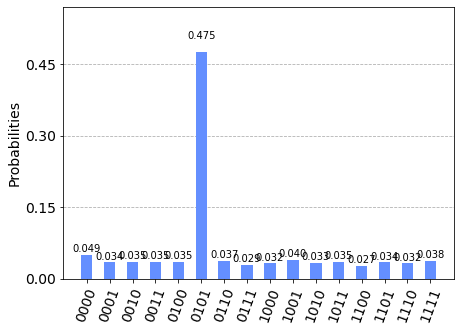

In [10]:
plot_histogram(count)

# the answer may seem inverted, i.e, 0101 is actually state 1010. that's just the notation used by qiskit.

We can see that the entry 1010 has a higher probability of appearing as compared to all the other entries. Note that we have only done the grover method once and yet got a decent answer. I encourage you to try and iterate this method multiple times to see the increase or decrease in probability. For a larger qubit number we may have to do this multiple times to get a decent probability. 

However, if you cross a certain number of iterations the amplitude of the expected states starts to come down again. This is depicted in the link [here](https://www.sciencedirect.com/topics/mathematics/quantum-search-algorithm) through this diagram for 2 and 10 qubits. Thus, the number of iterations $\sqrt{N}$ is usually a good number to stick to in the case of a single search item. If you are searching for "m" items then the number of iterations you'll have to do decreases to $\sqrt{\frac{N}{m}}$. This is why Grover's algorithm has an order of complexity O($\sqrt{N}$). 

<img src="images/grov_2_10.png" width="400px">

<center><a href="https://www.sciencedirect.com/topics/mathematics/quantum-search-algorithm">source</a></center>

Now that we have learnt how to apply Grover's algorithm for searching a certain entry, let's see how it can be used to solve something called a satisfiability problem. And in particular we will be dealing with a Boolean satisfiability problem called the 3-SAT problem

## What is a 3SAT problem? 

A boolean satisfiability problem is the task of assigning the varibales in a function with boolean values - `True` and `False` - such that the entire function turns out to be `True`. To understand this let's look at a specific equation below: 

$$ f(v_{1}, v_{2}, v_{3}) = (\neg v_{1} \vee v_{2} \vee v_{3}) \wedge (v_{1} \vee \neg v_{2} \vee \neg v_{3}) \wedge (v_{1} \vee v_{2} \vee \neg v_{3})$$

Here, 

* $v_1, v_2, v_3$ are the boolean variables which can take values `True` or `False` and are called **literals**
* $(\neg v_{1} \vee v_{2} \vee v_{3})$ and $(\neg v_{1} \vee v_{2} \vee v_{3})$ are called **clauses**
* $\vee$ is the **logical OR** operator and is called a **disjunction**. 
* $\wedge$ is the **logical AND** operator and is called a **conjunction**. 
* $\neg$ is the **logical NOT** operator and is called a **negation**. 

As each clause is a disjunction of exactly three literals it is called a 3SAT problem. And more specifically as it is in the form of a conjunction of disjunction of literals it is in something called the conjunctive normal form (CNF).

**Satisfiabiltiy Problem**: Find the right combination of boolean values for $v_1, v_2$ and $v_3$ such that the whole function $ f(v_{1}, v_{2}, v_{3})$ is `True`

A primitive approach would be to brute force all the possible inputs and look for which one of them gives an output of 1 for our function

| v_1 | v_2 | v_3 |f(v_1, v_2, v_3) |
|:-----:|:-----:|:-----:|:-----------------------:|
|0      | 0     | 0     | 1                       |
|0      | 0     | 1     | 0                       |
|0      | 1     | 0     | 1                       |
|0      | 1     | 1     | 0                       |
|1      | 0     | 0     | 0                       |
|1      | 0     | 1     | 1                       |
|1      | 1     | 0     | 1                       |
|1      | 1     | 1     | 1                       |

Now let's try to solve the same problem using Grover's algorithm


## Solving a 3SAT problem using Grover's algorithm 

This problem can be thought of as searching for the right combination of boolean values for the input variables which render our function true. The main step of grover's algorithm as we know is building the oracle such that it flips our |-> state when it finds the solution, thus tagging them with a phase. Once the flip occurs, grover's will take care of amplifying the probability of those tagged states and they show up more often when we repeat this experiment for a few thousand shots. 

This means that the main part of the problem is to build the oracle which detects these states and tags them. Let's get on with that. 

To build the complete oracle an idea we would be: 

* Create oracles for each clause and store the result of whether or not they are true in separate qubits
* Then perform an AND operation on all these stored qubits to get the final result depending onw hich we will flip our |-> state. 

To do this we should be able to form oracles for each clause. Take for example $(\neg v_{1} \vee v_{2} \vee v_{3})$. The result of this clause is nothing but a **logical OR** $v_1$, $v_2$ and $v_3$. For this purpose we need a three qubit OR gate. Let's build it. 

#### 2 qubit OR gate

Starting with a 2 qubit OR gate. This is the truth table: 

| a | b | a OR b |
|:--:|:--:|:--:|
|0|0|0|
|0|1|1|
|1|0|1|
|1|1|1|

In [11]:
q = QuantumRegister(3)
qc = QuantumCircuit(q)
qc.cx(0, 2)
qc.cx(1, 2)
qc.ccx(0,1,2)
qc.draw()

q7_0: ──■─────────■──
        │         │  
q7_1: ──┼────■────■──
      ┌─┴─┐┌─┴─┐┌─┴─┐
q7_2: ┤ X ├┤ X ├┤ X ├
      └───┘└───┘└───┘

Feel free to give the first two qubits values of |0> or |1> and computing the third qubit's value to crosscheck if the truth table stands corrected. 

#### 3 qubit OR gate

Similarly a 3 qubit OR gate looks like: 

| a | b | c | a OR b OR c |
|:--:|:--:|:--:|:--:|
|0|0|0|0|
|0|0|1|1|
|0|1|0|1|
|0|1|1|1|
|1|0|0|1|
|1|0|1|1|
|1|1|0|1|
|1|1|1|1|

In [12]:
def quantum_OR(qc, a, b, c, target, ancilla):
    qc.cx(a, target)
    qc.cx(b, target)
    qc.cx(c, target)
    qc.ccx(a,b,target)
    qc.ccx(b,c,target)
    qc.ccx(a,c,target)
    qc.mct([a,b,c],target,ancilla)
    qc.draw()

In [13]:
q = QuantumRegister(5) # 3 inputs, one target, one ancilla
qc = QuantumCircuit(q)
quantum_OR(qc, 0, 1, 2, 3, 4)
qc.draw()

q8_0: ──■──────────────■─────────■────■──
        │              │         │    │  
q8_1: ──┼────■─────────■────■────┼────■──
        │    │         │    │    │    │  
q8_2: ──┼────┼────■────┼────■────■────■──
      ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐
q8_3: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├
      └───┘└───┘└───┘└───┘└───┘└───┘└───┘
q8_4: ───────────────────────────────────

The best way to understand what the circuit is doing would be to place all the possible inputs and test whether hte truth table is satisfied. Now, back to our problem of finding an oracle for a specific clause.  

## Creating an oracle for each clause 

Let's build our circuit with 8 qubits: 
* **(qubit numbers: 0, 1, 2)** &emsp;- 3 qubits for our input boolean variables $v_1$, $v_2$ and $v_3$
* **(qubit numbers: 3)**&emsp;&emsp;&emsp;&emsp;- 1 qubit for storing the |-> state
* **(qubit numbers: 4, 5, 6)** &emsp;- 3 qubits for storing the outputs of the three clauses in our equation
* **(qubit numbers: 7)**&emsp;&emsp;&emsp;&emsp;- 1 ancilla qubit for our 3-qubit mct gates (3 qubit AND gates require one ancilla) (as explaiend about regarding mct gates)

And our solutions will be stored in a classical register of size 3 

### Initialisation and Equal superpostion

In [14]:
q = QuantumRegister(8)
c = ClassicalRegister(3)
qc = QuantumCircuit(q, c)

In [15]:
# initialize our input qubits in a superposition of all possible states 
qc.x(q[3]) # |-> state qubit
qc.h(q[0:4])
qc.barrier(q)
qc.draw()

┌───┐      ░ 
q9_0: ┤ H ├──────░─
      ├───┤      ░ 
q9_1: ┤ H ├──────░─
      ├───┤      ░ 
q9_2: ┤ H ├──────░─
      ├───┤┌───┐ ░ 
q9_3: ┤ X ├┤ H ├─░─
      └───┘└───┘ ░ 
q9_4: ───────────░─
                 ░ 
q9_5: ───────────░─
                 ░ 
q9_6: ───────────░─
                 ░ 
q9_7: ───────────░─
                 ░ 
c1: 3/═════════════

### Oracle for $(\neg v_{1} \vee v_{2} \vee v_{3})$

Apart from the negation on $v_1$ this is just a logical OR on three qubits. So, we apply an X gate to the first qubit and then the 3 qubit logical OR. The result of this will be stored in qubit number 4. 

In [16]:
qc.x(0)
quantum_OR(qc,0, 1, 2, 4, 7)
qc.draw()

┌───┐      ░ ┌───┐                                   
q9_0: ┤ H ├──────░─┤ X ├──■──────────────■─────────■────■──
      ├───┤      ░ └───┘  │              │         │    │  
q9_1: ┤ H ├──────░────────┼────■─────────■────■────┼────■──
      ├───┤      ░        │    │         │    │    │    │  
q9_2: ┤ H ├──────░────────┼────┼────■────┼────■────■────■──
      ├───┤┌───┐ ░        │    │    │    │    │    │    │  
q9_3: ┤ X ├┤ H ├─░────────┼────┼────┼────┼────┼────┼────┼──
      └───┘└───┘ ░      ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐
q9_4: ───────────░──────┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├
                 ░      └───┘└───┘└───┘└───┘└───┘└───┘└───┘
q9_5: ───────────░─────────────────────────────────────────
                 ░                                         
q9_6: ───────────░─────────────────────────────────────────
                 ░                                         
q9_7: ───────────░─────────────────────────────────────────
                 ░                                         
c1: 3/═════════════════════════════════════════════════════

**Important Note:** You may think we are done with the oracle but we still have one important step to do: Cleaning the altered qubits (if we are going to use them later in the circuit). For example, we have applied an X gate to qubit number 0. Now, when we use qubit 0 for the oracle of our next clause it will not give use the required result as the value of qubit 0 has been changed. To counteract this we need to clean qubit number zero by taking it back to the state that it was in. This, in our case, can be done by just re-applying the X gate to qubit zero, bringing it back to its initial state. 

In [17]:
# cleaning qubit zero
qc.x(0)
qc.barrier()
qc.draw()

┌───┐      ░ ┌───┐                                   ┌───┐ ░ 
q9_0: ┤ H ├──────░─┤ X ├──■──────────────■─────────■────■──┤ X ├─░─
      ├───┤      ░ └───┘  │              │         │    │  └───┘ ░ 
q9_1: ┤ H ├──────░────────┼────■─────────■────■────┼────■────────░─
      ├───┤      ░        │    │         │    │    │    │        ░ 
q9_2: ┤ H ├──────░────────┼────┼────■────┼────■────■────■────────░─
      ├───┤┌───┐ ░        │    │    │    │    │    │    │        ░ 
q9_3: ┤ X ├┤ H ├─░────────┼────┼────┼────┼────┼────┼────┼────────░─
      └───┘└───┘ ░      ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐      ░ 
q9_4: ───────────░──────┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├──────░─
                 ░      └───┘└───┘└───┘└───┘└───┘└───┘└───┘      ░ 
q9_5: ───────────░───────────────────────────────────────────────░─
                 ░                                               ░ 
q9_6: ───────────░───────────────────────────────────────────────░─
                 ░                                               ░ 
q9_7: ───────────░───────────────────────────────────────────────░─
                 ░                                               ░ 
c1: 3/═════════════════════════════════════════════════════════════

### Oracle for $(v_{1} \vee \neg v_{2} \vee \neg v_{3})$

Similarly we can find the oracle for $(v_{1} \vee \neg v_{2} \vee \neg v_{3})$

In [18]:
qc.x([1, 2])
quantum_OR(qc,0, 1, 2, 5, 7)
qc.x([1, 2])
qc.barrier()
qc.draw()

┌───┐      ░ ┌───┐                                   ┌───┐ ░           »
q9_0: ┤ H ├──────░─┤ X ├──■──────────────■─────────■────■──┤ X ├─░────────■──»
      ├───┤      ░ └───┘  │              │         │    │  └───┘ ░ ┌───┐  │  »
q9_1: ┤ H ├──────░────────┼────■─────────■────■────┼────■────────░─┤ X ├──┼──»
      ├───┤      ░        │    │         │    │    │    │        ░ ├───┤  │  »
q9_2: ┤ H ├──────░────────┼────┼────■────┼────■────■────■────────░─┤ X ├──┼──»
      ├───┤┌───┐ ░        │    │    │    │    │    │    │        ░ └───┘  │  »
q9_3: ┤ X ├┤ H ├─░────────┼────┼────┼────┼────┼────┼────┼────────░────────┼──»
      └───┘└───┘ ░      ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐      ░        │  »
q9_4: ───────────░──────┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├──────░────────┼──»
                 ░      └───┘└───┘└───┘└───┘└───┘└───┘└───┘      ░      ┌─┴─┐»
q9_5: ───────────░───────────────────────────────────────────────░──────┤ X ├»
                 ░                                               ░      └───┘»
q9_6: ───────────░───────────────────────────────────────────────░───────────»
                 ░                                               ░           »
q9_7: ───────────░───────────────────────────────────────────────░───────────»
                 ░                                               ░           »
c1: 3/═══════════════════════════════════════════════════════════════════════»
                                                                             »
«                                          ░ 
«q9_0: ────────────■─────────■────■────────░─
«                  │         │    │  ┌───┐ ░ 
«q9_1: ──■─────────■────■────┼────■──┤ X ├─░─
«        │         │    │    │    │  ├───┤ ░ 
«q9_2: ──┼────■────┼────■────■────■──┤ X ├─░─
«        │    │    │    │    │    │  └───┘ ░ 
«q9_3: ──┼────┼────┼────┼────┼────┼────────░─
«        │    │    │    │    │    │        ░ 
«q9_4: ──┼────┼────┼────┼────┼────┼────────░─
«      ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐      ░ 
«q9_5: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├──────░─
«      └───┘└───┘└───┘└───┘└───┘└───┘      ░ 
«q9_6: ────────────────────────────────────░─
«                                          ░ 
«q9_7: ────────────────────────────────────░─
«                                          ░ 
«c1: 3/══════════════════════════════════════
«

### Oracle for $(v_{1} \vee v_{2} \vee \neg v_{3})$

In [19]:
qc.x(2)
quantum_OR(qc,0, 1, 2, 6, 7)
qc.x(2)
qc.barrier()
qc.draw()

┌───┐      ░ ┌───┐                                   ┌───┐ ░           »
q9_0: ┤ H ├──────░─┤ X ├──■──────────────■─────────■────■──┤ X ├─░────────■──»
      ├───┤      ░ └───┘  │              │         │    │  └───┘ ░ ┌───┐  │  »
q9_1: ┤ H ├──────░────────┼────■─────────■────■────┼────■────────░─┤ X ├──┼──»
      ├───┤      ░        │    │         │    │    │    │        ░ ├───┤  │  »
q9_2: ┤ H ├──────░────────┼────┼────■────┼────■────■────■────────░─┤ X ├──┼──»
      ├───┤┌───┐ ░        │    │    │    │    │    │    │        ░ └───┘  │  »
q9_3: ┤ X ├┤ H ├─░────────┼────┼────┼────┼────┼────┼────┼────────░────────┼──»
      └───┘└───┘ ░      ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐      ░        │  »
q9_4: ───────────░──────┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├──────░────────┼──»
                 ░      └───┘└───┘└───┘└───┘└───┘└───┘└───┘      ░      ┌─┴─┐»
q9_5: ───────────░───────────────────────────────────────────────░──────┤ X ├»
                 ░                                               ░      └───┘»
q9_6: ───────────░───────────────────────────────────────────────░───────────»
                 ░                                               ░           »
q9_7: ───────────░───────────────────────────────────────────────░───────────»
                 ░                                               ░           »
c1: 3/═══════════════════════════════════════════════════════════════════════»
                                                                             »
«                                          ░                               »
«q9_0: ────────────■─────────■────■────────░────────■──────────────■───────»
«                  │         │    │  ┌───┐ ░        │              │       »
«q9_1: ──■─────────■────■────┼────■──┤ X ├─░────────┼────■─────────■────■──»
«        │         │    │    │    │  ├───┤ ░ ┌───┐  │    │         │    │  »
«q9_2: ──┼────■────┼────■────■────■──┤ X ├─░─┤ X ├──┼────┼────■────┼────■──»
«        │    │    │    │    │    │  └───┘ ░ └───┘  │    │    │    │    │  »
«q9_3: ──┼────┼────┼────┼────┼────┼────────░────────┼────┼────┼────┼────┼──»
«        │    │    │    │    │    │        ░        │    │    │    │    │  »
«q9_4: ──┼────┼────┼────┼────┼────┼────────░────────┼────┼────┼────┼────┼──»
«      ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐      ░        │    │    │    │    │  »
«q9_5: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├──────░────────┼────┼────┼────┼────┼──»
«      └───┘└───┘└───┘└───┘└───┘└───┘      ░      ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐»
«q9_6: ────────────────────────────────────░──────┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├»
«                                          ░      └───┘└───┘└───┘└───┘└───┘»
«q9_7: ────────────────────────────────────░───────────────────────────────»
«                                          ░                               »
«c1: 3/════════════════════════════════════════════════════════════════════»
«                                                                          »
«                      ░ 
«q9_0: ──■────■────────░─
«        │    │        ░ 
«q9_1: ──┼────■────────░─
«        │    │  ┌───┐ ░ 
«q9_2: ──■────■──┤ X ├─░─
«        │    │  └───┘ ░ 
«q9_3: ──┼────┼────────░─
«        │    │        ░ 
«q9_4: ──┼────┼────────░─
«        │    │        ░ 
«q9_5: ──┼────┼────────░─
«      ┌─┴─┐┌─┴─┐      ░ 
«q9_6: ┤ X ├┤ X ├──────░─
«      └───┘└───┘      ░ 
«q9_7: ────────────────░─
«                      ░ 
«c1: 3/══════════════════
«

### Final Conjugation 

Now that we have the result of each of our clauses stored in qubits 4, 5 and 6 - We should apply a logical AND operation on them and the sign bit (|->) stored in qubit number 3 must be flipped if the output of the AND operation is 1. This will complete the oracle for our specific problem

In [20]:
qc.mct([4, 5, 6], 3 , 7)
qc.barrier()
qc.draw()

┌───┐      ░ ┌───┐                                   ┌───┐ ░           »
q9_0: ┤ H ├──────░─┤ X ├──■──────────────■─────────■────■──┤ X ├─░────────■──»
      ├───┤      ░ └───┘  │              │         │    │  └───┘ ░ ┌───┐  │  »
q9_1: ┤ H ├──────░────────┼────■─────────■────■────┼────■────────░─┤ X ├──┼──»
      ├───┤      ░        │    │         │    │    │    │        ░ ├───┤  │  »
q9_2: ┤ H ├──────░────────┼────┼────■────┼────■────■────■────────░─┤ X ├──┼──»
      ├───┤┌───┐ ░        │    │    │    │    │    │    │        ░ └───┘  │  »
q9_3: ┤ X ├┤ H ├─░────────┼────┼────┼────┼────┼────┼────┼────────░────────┼──»
      └───┘└───┘ ░      ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐      ░        │  »
q9_4: ───────────░──────┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├──────░────────┼──»
                 ░      └───┘└───┘└───┘└───┘└───┘└───┘└───┘      ░      ┌─┴─┐»
q9_5: ───────────░───────────────────────────────────────────────░──────┤ X ├»
                 ░                                               ░      └───┘»
q9_6: ───────────░───────────────────────────────────────────────░───────────»
                 ░                                               ░           »
q9_7: ───────────░───────────────────────────────────────────────░───────────»
                 ░                                               ░           »
c1: 3/═══════════════════════════════════════════════════════════════════════»
                                                                             »
«                                          ░                               »
«q9_0: ────────────■─────────■────■────────░────────■──────────────■───────»
«                  │         │    │  ┌───┐ ░        │              │       »
«q9_1: ──■─────────■────■────┼────■──┤ X ├─░────────┼────■─────────■────■──»
«        │         │    │    │    │  ├───┤ ░ ┌───┐  │    │         │    │  »
«q9_2: ──┼────■────┼────■────■────■──┤ X ├─░─┤ X ├──┼────┼────■────┼────■──»
«        │    │    │    │    │    │  └───┘ ░ └───┘  │    │    │    │    │  »
«q9_3: ──┼────┼────┼────┼────┼────┼────────░────────┼────┼────┼────┼────┼──»
«        │    │    │    │    │    │        ░        │    │    │    │    │  »
«q9_4: ──┼────┼────┼────┼────┼────┼────────░────────┼────┼────┼────┼────┼──»
«      ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐      ░        │    │    │    │    │  »
«q9_5: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├──────░────────┼────┼────┼────┼────┼──»
«      └───┘└───┘└───┘└───┘└───┘└───┘      ░      ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐»
«q9_6: ────────────────────────────────────░──────┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├»
«                                          ░      └───┘└───┘└───┘└───┘└───┘»
«q9_7: ────────────────────────────────────░───────────────────────────────»
«                                          ░                               »
«c1: 3/════════════════════════════════════════════════════════════════════»
«                                                                          »
«                      ░       ░ 
«q9_0: ──■────■────────░───────░─
«        │    │        ░       ░ 
«q9_1: ──┼────■────────░───────░─
«        │    │  ┌───┐ ░       ░ 
«q9_2: ──■────■──┤ X ├─░───────░─
«        │    │  └───┘ ░ ┌───┐ ░ 
«q9_3: ──┼────┼────────░─┤ X ├─░─
«        │    │        ░ └─┬─┘ ░ 
«q9_4: ──┼────┼────────░───■───░─
«        │    │        ░   │   ░ 
«q9_5: ──┼────┼────────░───■───░─
«      ┌─┴─┐┌─┴─┐      ░   │   ░ 
«q9_6: ┤ X ├┤ X ├──────░───■───░─
«      └───┘└───┘      ░       ░ 
«q9_7: ────────────────░───────░─
«                      ░       ░ 
«c1: 3/══════════════════════════
«

### Amplitude Amplification

Let us now apply the diffusion operator to amplify the amplitude of our solutions

In [21]:
qc.barrier(q)
qc.h(q[0:3])
qc.x(q[0:3])
qc.barrier(q)
qc.h(q[2])
qc.barrier(q)
qc.mct([q[0], q[1]], q[2], q[7])   
qc.barrier(q)
qc.h(q[2])
qc.barrier(q)
qc.x(q[0:3])
qc.h(q[0:3])
qc.barrier(q)
qc.draw()

┌───┐      ░ ┌───┐                                   ┌───┐ ░           »
q9_0: ┤ H ├──────░─┤ X ├──■──────────────■─────────■────■──┤ X ├─░────────■──»
      ├───┤      ░ └───┘  │              │         │    │  └───┘ ░ ┌───┐  │  »
q9_1: ┤ H ├──────░────────┼────■─────────■────■────┼────■────────░─┤ X ├──┼──»
      ├───┤      ░        │    │         │    │    │    │        ░ ├───┤  │  »
q9_2: ┤ H ├──────░────────┼────┼────■────┼────■────■────■────────░─┤ X ├──┼──»
      ├───┤┌───┐ ░        │    │    │    │    │    │    │        ░ └───┘  │  »
q9_3: ┤ X ├┤ H ├─░────────┼────┼────┼────┼────┼────┼────┼────────░────────┼──»
      └───┘└───┘ ░      ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐      ░        │  »
q9_4: ───────────░──────┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├──────░────────┼──»
                 ░      └───┘└───┘└───┘└───┘└───┘└───┘└───┘      ░      ┌─┴─┐»
q9_5: ───────────░───────────────────────────────────────────────░──────┤ X ├»
                 ░                                               ░      └───┘»
q9_6: ───────────░───────────────────────────────────────────────░───────────»
                 ░                                               ░           »
q9_7: ───────────░───────────────────────────────────────────────░───────────»
                 ░                                               ░           »
c1: 3/═══════════════════════════════════════════════════════════════════════»
                                                                             »
«                                          ░                               »
«q9_0: ────────────■─────────■────■────────░────────■──────────────■───────»
«                  │         │    │  ┌───┐ ░        │              │       »
«q9_1: ──■─────────■────■────┼────■──┤ X ├─░────────┼────■─────────■────■──»
«        │         │    │    │    │  ├───┤ ░ ┌───┐  │    │         │    │  »
«q9_2: ──┼────■────┼────■────■────■──┤ X ├─░─┤ X ├──┼────┼────■────┼────■──»
«        │    │    │    │    │    │  └───┘ ░ └───┘  │    │    │    │    │  »
«q9_3: ──┼────┼────┼────┼────┼────┼────────░────────┼────┼────┼────┼────┼──»
«        │    │    │    │    │    │        ░        │    │    │    │    │  »
«q9_4: ──┼────┼────┼────┼────┼────┼────────░────────┼────┼────┼────┼────┼──»
«      ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐      ░        │    │    │    │    │  »
«q9_5: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├──────░────────┼────┼────┼────┼────┼──»
«      └───┘└───┘└───┘└───┘└───┘└───┘      ░      ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐»
«q9_6: ────────────────────────────────────░──────┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├»
«                                          ░      └───┘└───┘└───┘└───┘└───┘»
«q9_7: ────────────────────────────────────░───────────────────────────────»
«                                          ░                               »
«c1: 3/════════════════════════════════════════════════════════════════════»
«                                                                          »
«                      ░       ░  ░ ┌───┐┌───┐ ░       ░       ░       ░ ┌───┐»
«q9_0: ──■────■────────░───────░──░─┤ H ├┤ X ├─░───────░───■───░───────░─┤ X ├»
«        │    │        ░       ░  ░ ├───┤├───┤ ░       ░   │   ░       ░ ├───┤»
«q9_1: ──┼────■────────░───────░──░─┤ H ├┤ X ├─░───────░───■───░───────░─┤ X ├»
«        │    │  ┌───┐ ░       ░  ░ ├───┤├───┤ ░ ┌───┐ ░ ┌─┴─┐ ░ ┌───┐ ░ ├───┤»
«q9_2: ──■────■──┤ X ├─░───────░──░─┤ H ├┤ X ├─░─┤ H ├─░─┤ X ├─░─┤ H ├─░─┤ X ├»
«        │    │  └───┘ ░ ┌───┐ ░  ░ └───┘└───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘»
«q9_3: ──┼────┼────────░─┤ X ├─░──░────────────░───────░───────░───────░──────»
«        │    │        ░ └─┬─┘ ░  ░            ░       ░       ░       ░      »
«q9_4: ──┼────┼────────░───■───░──░────────────░───────░───────░───────░──────»
«        │    │        ░   │   ░  ░            ░       ░       ░       ░      »
«q9_5: ──┼────┼────────░───■───░──░────────────░───────░───────░───────░──────»
«      ┌─┴─┐┌─┴─┐      ░   │   ░  ░            ░       ░       ░       ░      »
«q

### Adding Measurements

After adding the measurements, this is the final circuit: 

In [22]:
qc.measure(q[0:3], c[0:3])
qc.draw()

┌───┐      ░ ┌───┐                                   ┌───┐ ░           »
q9_0: ┤ H ├──────░─┤ X ├──■──────────────■─────────■────■──┤ X ├─░────────■──»
      ├───┤      ░ └───┘  │              │         │    │  └───┘ ░ ┌───┐  │  »
q9_1: ┤ H ├──────░────────┼────■─────────■────■────┼────■────────░─┤ X ├──┼──»
      ├───┤      ░        │    │         │    │    │    │        ░ ├───┤  │  »
q9_2: ┤ H ├──────░────────┼────┼────■────┼────■────■────■────────░─┤ X ├──┼──»
      ├───┤┌───┐ ░        │    │    │    │    │    │    │        ░ └───┘  │  »
q9_3: ┤ X ├┤ H ├─░────────┼────┼────┼────┼────┼────┼────┼────────░────────┼──»
      └───┘└───┘ ░      ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐      ░        │  »
q9_4: ───────────░──────┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├──────░────────┼──»
                 ░      └───┘└───┘└───┘└───┘└───┘└───┘└───┘      ░      ┌─┴─┐»
q9_5: ───────────░───────────────────────────────────────────────░──────┤ X ├»
                 ░                                               ░      └───┘»
q9_6: ───────────░───────────────────────────────────────────────░───────────»
                 ░                                               ░           »
q9_7: ───────────░───────────────────────────────────────────────░───────────»
                 ░                                               ░           »
c1: 3/═══════════════════════════════════════════════════════════════════════»
                                                                             »
«                                          ░                               »
«q9_0: ────────────■─────────■────■────────░────────■──────────────■───────»
«                  │         │    │  ┌───┐ ░        │              │       »
«q9_1: ──■─────────■────■────┼────■──┤ X ├─░────────┼────■─────────■────■──»
«        │         │    │    │    │  ├───┤ ░ ┌───┐  │    │         │    │  »
«q9_2: ──┼────■────┼────■────■────■──┤ X ├─░─┤ X ├──┼────┼────■────┼────■──»
«        │    │    │    │    │    │  └───┘ ░ └───┘  │    │    │    │    │  »
«q9_3: ──┼────┼────┼────┼────┼────┼────────░────────┼────┼────┼────┼────┼──»
«        │    │    │    │    │    │        ░        │    │    │    │    │  »
«q9_4: ──┼────┼────┼────┼────┼────┼────────░────────┼────┼────┼────┼────┼──»
«      ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐      ░        │    │    │    │    │  »
«q9_5: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├──────░────────┼────┼────┼────┼────┼──»
«      └───┘└───┘└───┘└───┘└───┘└───┘      ░      ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐»
«q9_6: ────────────────────────────────────░──────┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├»
«                                          ░      └───┘└───┘└───┘└───┘└───┘»
«q9_7: ────────────────────────────────────░───────────────────────────────»
«                                          ░                               »
«c1: 3/════════════════════════════════════════════════════════════════════»
«                                                                          »
«                      ░       ░  ░ ┌───┐┌───┐ ░       ░       ░       ░ ┌───┐»
«q9_0: ──■────■────────░───────░──░─┤ H ├┤ X ├─░───────░───■───░───────░─┤ X ├»
«        │    │        ░       ░  ░ ├───┤├───┤ ░       ░   │   ░       ░ ├───┤»
«q9_1: ──┼────■────────░───────░──░─┤ H ├┤ X ├─░───────░───■───░───────░─┤ X ├»
«        │    │  ┌───┐ ░       ░  ░ ├───┤├───┤ ░ ┌───┐ ░ ┌─┴─┐ ░ ┌───┐ ░ ├───┤»
«q9_2: ──■────■──┤ X ├─░───────░──░─┤ H ├┤ X ├─░─┤ H ├─░─┤ X ├─░─┤ H ├─░─┤ X ├»
«        │    │  └───┘ ░ ┌───┐ ░  ░ └───┘└───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘»
«q9_3: ──┼────┼────────░─┤ X ├─░──░────────────░───────░───────░───────░──────»
«        │    │        ░ └─┬─┘ ░  ░            ░       ░       ░       ░      »
«q9_4: ──┼────┼────────░───■───░──░────────────░───────░───────░───────░──────»
«        │    │        ░   │   ░  ░            ░       ░       ░       ░      »
«q9_5: ──┼────┼────────░───■───░──░────────────░───────░───────░───────░──────»
«      ┌─┴─┐┌─┴─┐      ░   │   ░  ░            ░       ░       ░       ░      »
«q

### Running the circuit and cross-checking results

In [23]:
# running and getting results 

backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)

# if you would like to use the wasm simulator on the cloud then comment the above lines and uncomment the lines below 
# backend = provider.get_backend('ibmq_qasm_simulator')
# job = execute(qc, backend=backend, shots=8000, seed_simulator=12345, backend_options={"fusion_enable":True})
result = job.result()
count = result.get_counts()
print(count)

{'000': 35, '001': 289, '010': 29, '011': 25, '100': 294, '101': 28, '110': 271, '111': 29}


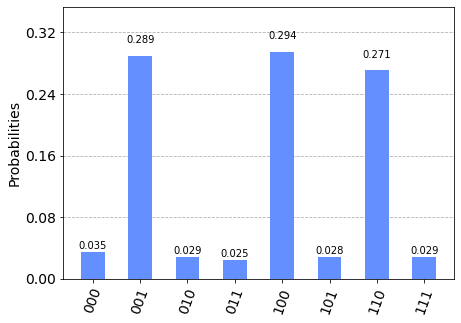

In [24]:
plot_histogram(count)

Hmmm, something seems wrong... We were expecting the results to be {|000>, |010>, |110>, |101> and |111>} however only those outputs have lesser probability and the ones we expected to have a lower probability are actually higher!

### For the curious

As you can see our results are exactly opposite of what we expected them to be. Your mission should you choose to accept it is to dig into the algorithm and figure out what went wrong. Further, find what should be done to change the situation and get back the probability distribution we are looking for. 

For your reference check out the notebook chapter on [Solving Satisfiability Problems using Grover's Algorithm](https://qiskit.org/textbook/ch-applications/satisfiability-grover.html) and use the in-built implementation of Grover's from qiskit Aqua to cross-check your results. 

**Hint**: Think about what parts of the algorithm affect probabilities

Here are a few other things you can try to do: 
* try to reduce the cost of the circuit, i.e, by using lesser number of double qubit gates. 
* Repurpose this such that it works for any k-SAT problem

If you would like to check the cost of your circuit as defined by **cost of the circuit = 1 $\times$ number of single qubit gates + 10 $\times$ number of cx gates** and can be calculated by the formula below taken from the [Qiskit Challenge 2019 notebook](https://github.com/quantum-challenge/2019/blob/master/problems/week1/week1_en.ipynb). 

In [29]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
 

def circuit_cost(qc):
    pass_ = Unroller(['u3', 'cx'])
    pm = PassManager(pass_)
    new_circuit = pm.run(qc)
    count = new_circuit.count_ops()
    print(count)
    cost = int(qc.count_ops['u3']) + int(qc.count_ops['cx'])
    print("Cost of the circuit is {}".format(cost))
    return cost

In [30]:
circuit_cost(qc)

QiskitError: "Error decomposing node p: 'NoneType' object has no attribute 'data'"

### Next Steps? 

Now that we've learnt this algorithm, what types of problems can we tackle? The best way to learn this is by trying it out yourself. Here are two challenges which are based on Grover's algorithm: 

* [Qiskit Challenge 2019](https://github.com/quantum-challenge/2019/blob/master/problems/final/Final_en.ipynb)  <- My personal favourite and the competition that got me into quantum computing    
* [Qiskit Challenge 2020](https://github.com/qiskit-community/IBMQuantumChallenge2020)

Good luck!

Here are a few resources to help you out with the problems: 
* [Qiskit Textbook - Grover's algorithm](https://qiskit.org/textbook/ch-algorithms/grover.html)   
* [Textbook chapter 6.4] - Quantum Computing for Computer Scientists (Noson S. Yanofsky, Mirco A. Mannucci)   
* Each of these challenges have their own reading material in their respective Github repos as well 

Once you've solved these problems and are now comfortable with one specific algorithm its time to learn more algorithms from the Qiskit Textbook and possibly start a small project of your own! 

If you're interested in understanding how to design and build qubits at the most intricate level of hardware, delving into the newly open-sourced [**Qiskit Metal**](https://qiskit.org/metal/) would be the way to go. 

If you would like to understand how to interact with these qubits at the level of pulses and understand how gates are actually applied, you can read up on **Qiskit Pulse** from [Chapter 6.1 of the Qiskit Textbook](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html). 